In [139]:
# read first Bengio et al. 2003 (MLP language model) paper

In [140]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [141]:
words = open("data/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [142]:
len(words)

32033

In [143]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [165]:
def build_dataset(words):
    block_size = 3 # context length: how many chars de we take to predict the next one?
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [166]:
# ---- rewrite
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [219]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [220]:
sum(p.nelement() for p in parameters)

11897

In [221]:
for p in parameters:
    p.requires_grad = True

In [224]:
# how to determine a reasonable learning rate
lre  = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [225]:
lossi = []
stepi = []

In [230]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f"{i}: {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.01 * p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

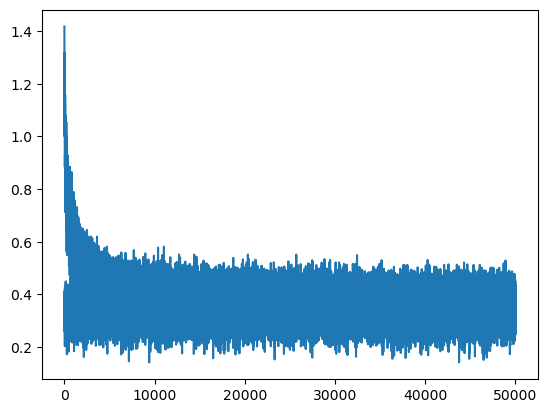

In [231]:
plt.plot(stepi, lossi)

In [232]:
print(loss.item())

1.9775453805923462


In [233]:
# eval
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1981, grad_fn=<NllLossBackward0>)

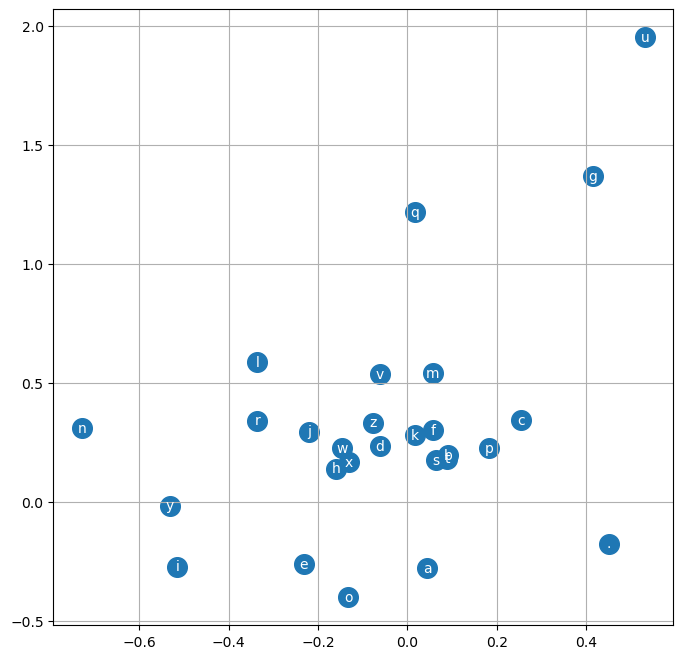

In [218]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

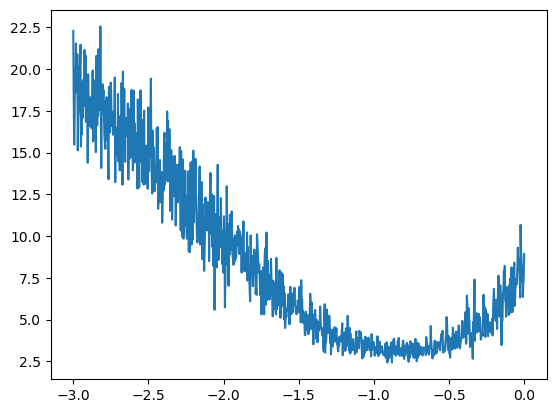

In [103]:
plt.plot(lri, lossi)
# showing that somwhere around [-1, -0.5] is the best learning rate (roughly 0.1 here best)

In [137]:
# data: training split, dev/validation split, test split
# 80%, 10%, 10%
# train the params, train the hyper-params, evaluate the performance